# **JPEG Compression and Decompression**

Imports necessary libraries for image processing and compression, including numpy for numerical operations, cv2 (OpenCV) for image manipulation, collections.Counter for frequency counting, and math.ceil for ceiling division.

In [43]:
import numpy as np
import cv2
from collections import Counter
from math import ceil

imgOriginal = None

This code block sets up an interactive file upload widget. It allows you to select an image file (like JPG, PNG, or BMP) from your computer. Once you upload a file, the handle_upload function processes it: it reads the image data, decodes it using OpenCV, and then stores the image in the global imgOriginal variable for use in other parts of the notebook.

In [44]:
from IPython.display import display
import ipywidgets as widgets

# Create a FileUpload widget
uploader = widgets.FileUpload(
    accept='.jpg,.jpeg,.png,.bmp,.tiff',  # Accepted file types
    multiple=False  # Allow only one file upload
)

# Display the uploader widget
print("Please upload your image file:")
display(uploader)

def handle_upload(change):
    global imgOriginal # Declare imgOriginal as global
    if uploader.value:
        # Get the first (and only) uploaded file's content
        uploaded_file_name = next(iter(uploader.value))
        uploaded_file_content = uploader.value[uploaded_file_name]['content']

        # Convert bytes to a numpy array
        nparr = np.frombuffer(uploaded_file_content, np.uint8)

        # Decode image using OpenCV
        img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)

        if img is not None:
            imgOriginal = img # Assign the uploaded image to imgOriginal
            print(f"Uploaded image '{uploaded_file_name}' shape: {imgOriginal.shape} and set as imgOriginal.")
        else:
            print(f"Error: Could not decode image '{uploaded_file_name}'. Make sure it's a valid image file.")

# Attach the handler function to the uploader's observe method
# The '_counter' traitlet changes when files are added or removed
uploader.observe(handle_upload, names='_counter')

Please upload your image file:


FileUpload(value={}, accept='.jpg,.jpeg,.png,.bmp,.tiff', description='Upload')

Uploaded image 'grumpy-cat-peeking.jpg' shape: (3840, 5120, 3) and set as imgOriginal.
Uploaded image 'pepper.bmp' shape: (512, 512, 3) and set as imgOriginal.
Uploaded image 'nms.jpg' shape: (2160, 1440, 3) and set as imgOriginal.
Uploaded image 'LeoMessi.jpg' shape: (2100, 3106, 3) and set as imgOriginal.
Uploaded image 'pepper.bmp' shape: (512, 512, 3) and set as imgOriginal.


## Compression

Defines the zigzag function, which converts a 2D matrix (like a quantized block of image data) into a 1D array using a zigzag scan pattern. This is a common step in JPEG compression.

In [56]:
def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output

Defines the trim function, which removes trailing zeros from a NumPy array. If the array becomes empty after trimming, it adds a single zero, which is likely used as the DC component in run-length encoding.

In [57]:
def trim(array: np.ndarray) -> np.ndarray:
    """
    in case the trim_zeros function returns an empty array, add a zero to the array to use as the DC component
    :param numpy.ndarray array: array to be trimmed
    :return numpy.ndarray:
    """
    trimmed = np.trim_zeros(array, 'b')
    if len(trimmed) == 0:
        trimmed = np.zeros(1)
    return trimmed

Defines the run_length_encoding function. It takes zigzagged coefficients and applies run-length encoding (RLE), distinguishing between DC components (represented by (size, amplitude)) and AC components (represented by (run_length, size, amplitude)). It also inserts 'EOB' (End Of Block) markers.

In [58]:
def run_length_encoding(array: np.ndarray) -> list:
    """
    finds the intermediary stream representing the zigzags
    format for DC components is <size><amplitude>
    format for AC components is <run_length, size> <Amplitude of non-zero>
    :param numpy.ndarray array: zigzag vectors in array
    :returns: run length encoded values as an array of tuples
    """
    encoded = list()
    run_length = 0
    eob = ("EOB",)

    for i in range(len(array)):
        for j in range(len(array[i])):
            trimmed = trim(array[i])
            if j == len(trimmed):
                encoded.append(eob)  # EOB
                break
            if i == 0 and j == 0:  # for the first DC component
                encoded.append((int(trimmed[j]).bit_length(), trimmed[j]))
            elif j == 0:  # to compute the difference between DC components
                diff = int(array[i][j] - array[i - 1][j])
                if diff != 0:
                    encoded.append((diff.bit_length(), diff))
                else:
                    encoded.append((1, diff))
                run_length = 0
            elif trimmed[j] == 0:  # increment run_length by one in case of a zero
                run_length += 1
            else:  # intermediary steam representation of the AC components
                encoded.append((run_length, int(trimmed[j]).bit_length(), trimmed[j]))
                run_length = 0
            # send EOB
        if not (encoded[len(encoded) - 1] == eob):
            encoded.append(eob)
    return encoded

Defines the get_freq_dict function, which calculates the frequency of each unique symbol in a given list or array. This frequency table is essential for building Huffman codes.

In [59]:
def get_freq_dict(array: list) -> dict:
    """
    returns a dict where the keys are the values of the array, and the values are their frequencies
    :param numpy.ndarray array: intermediary stream as array
    :return: frequency table
    """
    #
    data = Counter(array)
    result = {k: d / len(array) for k, d in data.items()}
    return result

Defines the find_huffman function, which generates a Huffman code for a given frequency distribution. It's a recursive function that merges the lowest probable pairs.

In [60]:
def find_huffman(p: dict) -> dict:
    """
    returns a Huffman code for an ensemble with distribution p
    :param dict p: frequency table
    :returns: huffman code for each symbol
    """
    # Base case of only two symbols, assign 0 or 1 arbitrarily; frequency does not matter
    if len(p) == 2:
        return dict(zip(p.keys(), ['0', '1']))

    # Create a new distribution by merging lowest probable pair
    p_prime = p.copy()
    a1, a2 = lowest_prob_pair(p)
    p1, p2 = p_prime.pop(a1), p_prime.pop(a2)
    p_prime[a1 + a2] = p1 + p2

    # Recurse and construct code on new distribution
    c = find_huffman(p_prime)
    ca1a2 = c.pop(a1 + a2)
    c[a1], c[a2] = ca1a2 + '0', ca1a2 + '1'

    return c

Defines the lowest_prob_pair helper function, used by find_huffman to identify the two symbols with the lowest probabilities in a frequency distribution.

In [61]:
def lowest_prob_pair(p):
    # Return pair of symbols from distribution p with lowest probabilities
    sorted_p = sorted(p.items(), key=lambda x: x[1])
    return sorted_p[0][0], sorted_p[1][0]

Defines the standard quantization tables for JPEG compression: QTY for luminance (Y channel) and QTC for chrominance (Cb and Cr channels).

In [62]:
QTY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

QTC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

Defines the rgb_to_ycbcr function, which converts an image from BGR color space to YCbCr color space using the BT.601 standard formulas. This is a crucial step in JPEG as it separates luminance from chrominance.

In [63]:
import numpy as np
import cv2


def rgb_to_ycbcr(image_bgr: np.ndarray) -> np.ndarray:
    """
    Converts an image from BGR color space to YCbCr color space using
    mathematical formulas (BT.601 standard).
    Assumes the input image is in BGR format (common for OpenCV).

    Args:
        image_bgr (np.ndarray): The input image in BGR format (dtype=uint8).

    Returns:
        np.ndarray: The image converted to YCbCr format (dtype=uint8).
    """
    # Convert to float for calculations
    bgr_float = image_bgr.astype(np.float32)
    B = bgr_float[:, :, 0]
    G = bgr_float[:, :, 1]
    R = bgr_float[:, :, 2]

    # YCbCr conversion formulas (ITU-R BT.601 coefficients, full range 0-255)
    Y  = (0.299   * R + 0.587   * G + 0.114   * B)
    Cb = (-0.168736 * R - 0.331264 * G + 0.500   * B + 128)
    Cr = (0.500   * R - 0.418688 * G - 0.081312 * B + 128)

    # Stack channels and clip to [0, 255] range
    ycbcr_image = np.stack([Y, Cb, Cr], axis=-1)
    ycbcr_image = np.clip(ycbcr_image, 0, 255).astype(np.uint8)

    return ycbcr_image


This is a comprehensive cell that performs the main JPEG compression steps:


*   Reads the original image and converts it to YCbCr.
*   Separates Y, Cb, Cr channels and subtracts 128 (level shifting).


*   Performs 4:2:2 chrominance subsampling.


*   Pads channels to be multiples of windowSize (8x8 blocks).

*   Applies Discrete Cosine Transform (DCT) to 8x8 blocks of each channel.



*   Quantizes the DCT coefficients using QTY and QTC.


*   Performs zigzag scanning on the quantized blocks.


*   Applies run-length encoding (run_length_encoding).


*   Generates Huffman frequency tables (get_freq_dict).

*   Creates Huffman codes (find_huffman).



*   Encodes the data into bitstreams and writes them to a file named "CompressedImage.asfh".

*   Calculates and prints the compression ratio.

In [64]:
def jpeg_compress(img_bgr, QTY, QTC, windowSize):
    # read image
    img = rgb_to_ycbcr(img_bgr)
    width = len(img[0])
    height = len(img)
    y = np.zeros((height, width), np.float32) + img[:, :, 0]
    cb = np.zeros((height, width), np.float32) + img[:, :, 1]
    cr = np.zeros((height, width), np.float32) + img[:, :, 2]
    # size of the image in bits before compression
    totalNumberOfBitsWithoutCompression = len(y) * len(y[0]) * 8 + len(cb) * len(cb[0]) * 8 + len(cr) * len(cr[0]) * 8
    # channel values should be normalized, hence subtract 128
    y = y - 128
    cr = cr - 128
    cb = cb - 128
    # 4: 2: 2 subsampling is used # another subsampling scheme can be used
    # thus chrominance channels should be sub-sampled
    # define subsampling factors in both horizontal and vertical directions
    SSH, SSV = 2, 2
    # filter the chrominance channels using a 2x2 averaging filter # another type of filter can be used
    crf = cv2.boxFilter(cr, ddepth=-1, ksize=(2, 2))
    cbf = cv2.boxFilter(cb, ddepth=-1, ksize=(2, 2))
    crSub = crf[::SSV, ::SSH]
    cbSub = cbf[::SSV, ::SSH]

    # check if padding is needed,
    # if yes define empty arrays to pad each channel DCT with zeros if necessary
    yWidth, yLength = ceil(len(y[0]) / windowSize) * windowSize, ceil(len(y) / windowSize) * windowSize
    if (len(y[0]) % windowSize == 0) and (len(y) % windowSize == 0):
        yPadded = y.copy()
    else:
        yPadded = np.zeros((yLength, yWidth))
        for i in range(len(y)):
            for j in range(len(y[0])):
                yPadded[i, j] += y[i, j]

    # chrominance channels have the same dimensions, meaning both can be padded in one loop
    cWidth, cLength = ceil(len(cbSub[0]) / windowSize) * windowSize, ceil(len(cbSub) / windowSize) * windowSize
    if (len(cbSub[0]) % windowSize == 0) and (len(cbSub) % windowSize == 0):
        crPadded = crSub.copy()
        cbPadded = cbSub.copy()
    # since chrominance channels have the same dimensions, one loop is enough
    else:
        crPadded = np.zeros((cLength, cWidth))
        cbPadded = np.zeros((cLength, cWidth))
        for i in range(len(crSub)):
            for j in range(len(crSub[0])):
                crPadded[i, j] += crSub[i, j]
                cbPadded[i, j] += cbSub[i, j]

    # get DCT of each channel
    # define three empty matrices
    yDct, crDct, cbDct = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))

    # number of iteration on x axis and y axis to calculate the luminance cosine transform values
    hBlocksForY = int(len(yDct[0]) / windowSize)  # number of blocks in the horizontal direction for luminance
    vBlocksForY = int(len(yDct) / windowSize)  # number of blocks in the vertical direction for luminance
    # number of iteration on x axis and y axis to calculate the chrominance channels cosine transforms values
    hBlocksForC = int(len(crDct[0]) / windowSize)  # number of blocks in the horizontal direction for chrominance
    vBlocksForC = int(len(crDct) / windowSize)  # number of blocks in the vertical direction for chrominance

    # define 3 empty matrices to store the quantized values
    yq, crq, cbq = np.zeros((yLength, yWidth)), np.zeros((cLength, cWidth)), np.zeros((cLength, cWidth))
    # and another 3 for the zigzags
    yZigzag = np.zeros(((vBlocksForY * hBlocksForY), windowSize * windowSize))
    crZigzag = np.zeros(((vBlocksForC * hBlocksForC), windowSize * windowSize))
    cbZigzag = np.zeros(((vBlocksForC * hBlocksForC), windowSize * windowSize))

    yCounter = 0
    for i in range(vBlocksForY):
        for j in range(hBlocksForY):
            yDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
                yPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
            yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
                yDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTY)
            yZigzag[yCounter] += zigzag(
                yq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
            yCounter += 1
    yZigzag = yZigzag.astype(np.int16)

    # either crq or cbq can be used to compute the number of blocks
    cCounter = 0
    for i in range(vBlocksForC):
        for j in range(hBlocksForC):
            crDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
                crPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
            crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
                crDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTC)
            crZigzag[cCounter] += zigzag(
                crq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
            cbDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = cv2.dct(
                cbPadded[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
            cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] = np.ceil(
                cbDct[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize] / QTC)
            cbZigzag[cCounter] += zigzag(
                cbq[i * windowSize: i * windowSize + windowSize, j * windowSize: j * windowSize + windowSize])
            cCounter += 1
    crZigzag = crZigzag.astype(np.int16)
    cbZigzag = cbZigzag.astype(np.int16)

    # find the run length encoding for each channel
    # then get the frequency of each component in order to form a Huffman dictionary
    yEncoded = run_length_encoding(yZigzag)
    yFrequencyTable = get_freq_dict(yEncoded)
    yHuffman = find_huffman(yFrequencyTable)

    crEncoded = run_length_encoding(crZigzag)
    crFrequencyTable = get_freq_dict(crEncoded)
    crHuffman = find_huffman(crFrequencyTable)

    cbEncoded = run_length_encoding(cbZigzag)
    cbFrequencyTable = get_freq_dict(cbEncoded)
    cbHuffman = find_huffman(cbFrequencyTable)

    # calculate the number of bits to transmit for each channel
    # and write them to an output file
    file = open("CompressedImage.bin", "w")
    yBitsToTransmit = str()
    for value in yEncoded:
        yBitsToTransmit += yHuffman[value]

    crBitsToTransmit = str()
    for value in crEncoded:
        crBitsToTransmit += crHuffman[value]

    cbBitsToTransmit = str()
    for value in cbEncoded:
        cbBitsToTransmit += cbHuffman[value]

    if file.writable():
        file.write(yBitsToTransmit + "\n" + crBitsToTransmit + "\n" + cbBitsToTransmit)
    file.close()

    print("\nY Bitstream (first 100 chars):", yBitsToTransmit[:100])
    print("Cr Bitstream (first 100 chars):", crBitsToTransmit[:100])
    print("Cb Bitstream (first 100 chars):", cbBitsToTransmit[:100])

    totalNumberOfBitsAfterCompression = len(yBitsToTransmit) + len(crBitsToTransmit) + len(cbBitsToTransmit)
    print(
        "Compression Ratio is " + str(
            np.round(totalNumberOfBitsWithoutCompression / totalNumberOfBitsAfterCompression, 1)))

    return {
        'yHuffman': yHuffman,
        'crHuffman': crHuffman,
        'cbHuffman': cbHuffman,
        'height': height,
        'width': width,
        'hBlocksForY': hBlocksForY,
        'vBlocksForY': vBlocksForY,
        'hBlocksForC': hBlocksForC,
        'vBlocksForC': vBlocksForC,
        'yLength': yLength,
        'yWidth': yWidth,
        'cLength': cLength,
        'cWidth': cWidth,
        'SSH': SSH,
        'SSV': SSV,
        'windowSize': windowSize
    }

Calls the jpeg_compress function to compress the input image

In [72]:
# Define the window size for block processing
windowSize = 8

# Check if imgOriginal is available before compression
if imgOriginal is not None:
    # Call the jpeg_compress function
    compression_results = jpeg_compress(imgOriginal, QTY, QTC, windowSize)

    # Unpack the results into global variables for decompression
    globals().update(compression_results)

    print("JPEG compression completed and parameters stored for decompression.")
else:
    print("Error: No image loaded for compression. Please ensure 'pepper.bmp' is present or upload an image.")


Y Bitstream (first 100 chars): 1101011111011110101001111111001011111001011001011111011000110011011001100111111000110001100111111010
Cr Bitstream (first 100 chars): 1101100101010101100010011110101000011101100011001000111001111001110001000011110110101110101010110111
Cb Bitstream (first 100 chars): 1110010000001100111001111111101010010011001111001110110111110000111101010111001001001111101100111011
Compression Ratio is 9.9
JPEG compression completed and parameters stored for decompression.


## Decompression

This cell performs the
full JPEG decompression process:





1.	build_reverse_huffman_map: Creates a map to decode Huffman bitstreams back to symbols.
2.	huffman_decode_stream: Decodes the bitstream using the reverse Huffman map.
3.	inverse_run_length_decoding: Reconstructs the zigzagged coefficients from the run-length encoded symbols.
4.	inverse_zigzag_scan: Reconstructs 8x8 blocks from their zigzagged 1D arrays.
5.	perform_inverse_block_idct_and_dequantization: De-quantizes and applies Inverse Discrete Cosine Transform (IDCT) to reconstruct the padded Y, Cb, Cr channels.
6.	Removes padding and adds 128 (undoing the level shift).
7.	Upsamples the chrominance channels (cr_upsampled, cb_upsampled) to the original image dimensions.
8.	Stacks the Y, Cb, Cr channels to form the reconstructed YCbCr image.
9.	Converts the YCbCr image back to BGR color space.
10.	Saves the reconstructed image as "ReconstructedImage.jpg".



Image successfully reconstructed and saved as ReconstructedImage.jpg
Reconstructed Image:


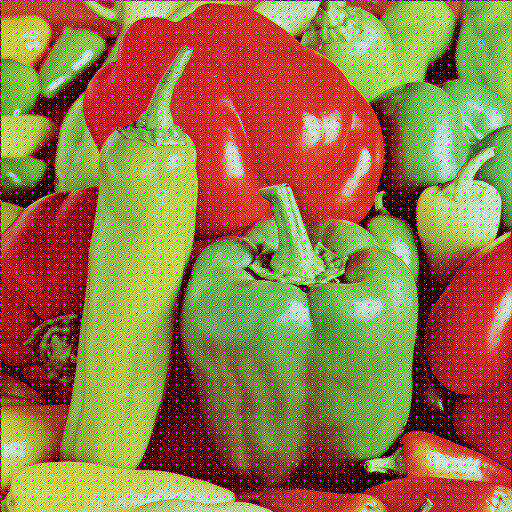

In [73]:
import numpy as np
import cv2
from math import ceil
from google.colab.patches import cv2_imshow # Import cv2_imshow for displaying images

def build_reverse_huffman_map(huffman_dict: dict) -> dict:
    """
    Builds a reverse Huffman map for decoding.

    Args:
        huffman_dict (dict): The Huffman encoding dictionary (e.g., {'symbol': '01'}).

    Returns:
        dict: A dictionary mapping bit sequences to symbols (e.g., {'01': 'symbol'}).
    """
    reverse_map = {}
    for symbol, code in huffman_dict.items():
        reverse_map[code] = symbol
    return reverse_map

def huffman_decode_stream(bitstream: str, reverse_huffman_map: dict) -> list:
    """
    Decodes a Huffman encoded bitstream into a list of original symbols.

    Args:
        bitstream (str): The concatenated string of Huffman encoded bits.
        reverse_huffman_map (dict): The reverse map for Huffman decoding.

    Returns:
        list: A list of decoded symbols (run-length encoded tuples or 'EOB').
    """
    decoded_symbols = []
    current_code = ""
    for bit in bitstream:
        current_code += bit
        if current_code in reverse_huffman_map:
            decoded_symbols.append(reverse_huffman_map[current_code])
            current_code = ""
    return decoded_symbols

def inverse_run_length_decoding(encoded_list: list, num_blocks: int, window_size: int) -> np.ndarray:
    """
    Performs inverse run-length encoding to reconstruct zigzagged coefficients.

    Args:
        encoded_list (list): List of decoded symbols from Huffman (tuples or 'EOB').
        num_blocks (int): Total number of 8x8 blocks.
        window_size (int): Size of the blocks (e.g., 8).

    Returns:
        np.ndarray: A 2D array of zigzagged coefficients for all blocks.
    """
    decoded_zigzag_coeffs = np.zeros((num_blocks, window_size * window_size), dtype=np.int16)
    encoded_list_idx = 0
    prev_dc = 0

    for block_idx in range(num_blocks):
        current_block_zigzag = np.zeros(window_size * window_size, dtype=np.int16)
        coeff_in_block_idx = 0

        if encoded_list_idx >= len(encoded_list):
            print(f"Warning: Ran out of encoded data before decoding all blocks. Expected {num_blocks}, decoded {block_idx}.")
            break

        # Decode DC component
        dc_entry = encoded_list[encoded_list_idx]
        if isinstance(dc_entry, tuple) and (len(dc_entry) == 2 or (len(dc_entry) == 3 and isinstance(dc_entry[0], int))):
            value = dc_entry[-1] # The actual amplitude or difference is the last element
            if block_idx == 0:
                current_block_zigzag[coeff_in_block_idx] = value
                prev_dc = value
            else:
                current_block_zigzag[coeff_in_block_idx] = prev_dc + value
                prev_dc = current_block_zigzag[coeff_in_block_idx]
            coeff_in_block_idx += 1
            encoded_list_idx += 1
        else:
            raise ValueError(f"Unexpected DC entry format at index {encoded_list_idx}: {dc_entry}. Expected a DC component, but found an EOB or malformed entry.")

        # Decode AC components until EOB or block is full
        while coeff_in_block_idx < window_size * window_size and encoded_list_idx < len(encoded_list):
            entry = encoded_list[encoded_list_idx]
            if entry == ("EOB",):
                encoded_list_idx += 1
                break

            if isinstance(entry, tuple) and len(entry) == 3: # (run_length, size, amplitude)
                run_length, _, value = entry # size is not needed for decoding here

                # Check if adding run_length and then the value would exceed block size
                if coeff_in_block_idx + run_length >= window_size * window_size:
                    # If run_length makes us go over, fill remaining with zeros and stop.
                    # Consume the current entry and then break.
                    print(f"Warning: AC run_length {run_length} from entry {entry} would exceed block size in block {block_idx} at encoded_list_idx {encoded_list_idx}.")
                    encoded_list_idx += 1 # Consume this entry
                    break # Block is effectively full/overfilled, stop AC processing

                coeff_in_block_idx += run_length # Add zeros for run length
                current_block_zigzag[coeff_in_block_idx] = value
                coeff_in_block_idx += 1
                encoded_list_idx += 1
            else:
                # This case implies an unexpected entry type that is not EOB or a valid AC component.
                # It could also mean the next entry is already the DC for the next block, if previous ACs filled the current block.
                break

        # After AC loop, ensure we consume the EOB for this block if it was not already consumed.
        # This handles cases where the `while` loop broke because `coeff_in_block_idx` filled the block.
        if encoded_list_idx < len(encoded_list) and encoded_list[encoded_list_idx] == ("EOB",):
            encoded_list_idx += 1 # Consume the EOB for the current block

        decoded_zigzag_coeffs[block_idx, :] = current_block_zigzag
    return decoded_zigzag_coeffs

def inverse_zigzag_scan(zigzag_vector: np.ndarray, window_size: int) -> np.ndarray:
    """
    Reconstructs an 8x8 block from its zigzag scanned 1D array.

    Args:
        zigzag_vector (np.ndarray): The 1D array of zigzagged coefficients.
        window_size (int): The size of the square block (e.g., 8).

    Returns:
        np.ndarray: The reconstructed 2D 8x8 block.
    """
    # This is the inverse of the zigzag function provided earlier.
    # The implementation is based on the logic in the original zigzag function.
    matrix = np.zeros((window_size, window_size), dtype=np.int16)
    h, v = 0, 0
    v_min, h_min = 0, 0
    v_max, h_max = window_size, window_size
    i = 0

    while (v < v_max) and (h < h_max) and (i < len(zigzag_vector)):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                matrix[v, h] = zigzag_vector[i]
                if h == h_max - 1:
                    v += 1
                else:
                    h += 1
                i += 1
            elif (h == h_max - 1) and (v < v_max - 1):  # last column
                matrix[v, h] = zigzag_vector[i]
                v += 1
                i += 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                matrix[v, h] = zigzag_vector[i]
                v -= 1
                h += 1
                i += 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                matrix[v, h] = zigzag_vector[i]
                h += 1
                i += 1
            elif h == h_min:  # first column
                matrix[v, h] = zigzag_vector[i]
                if v == v_max - 1:
                    h += 1
                else:
                    v += 1
                i += 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                matrix[v, h] = zigzag_vector[i]
                v += 1
                h -= 1
                i += 1

        if (v == v_max - 1) and (h == h_max - 1) and (i < len(zigzag_vector)):
            matrix[v,h] = zigzag_vector[i]
            i += 1

    return matrix

def perform_inverse_block_idct_and_dequantization(
    zigzagged_quantized_coeffs_flat: np.ndarray,
    q_table: np.ndarray,
    window_size: int,
    h_blocks: int,
    v_blocks: int,
    padded_channel_shape: tuple
) -> np.ndarray:
    """
    Performs inverse quantization and Inverse Discrete Cosine Transform (IDCT) block-wise.

    Args:
        zigzagged_quantized_coeffs_flat (np.ndarray): 2D array of zigzagged quantized coefficients.
        q_table (np.ndarray): The quantization table used for the channel.
        window_size (int): The size of the square blocks (e.g., 8).
        h_blocks (int): Number of horizontal blocks.
        v_blocks (int): Number of vertical blocks.
        padded_channel_shape (tuple): The (height, width) of the original padded channel.

    Returns:
        np.ndarray: The reconstructed padded channel (before removing padding).
    """
    reconstructed_padded_channel = np.zeros(padded_channel_shape, dtype=np.float32)
    coeff_idx = 0
    for i in range(v_blocks):
        for j in range(h_blocks):
            # 1. Inverse Zigzag Scan: Reconstruct the 8x8 quantized block
            zigzag_vector = zigzagged_quantized_coeffs_flat[coeff_idx, :]
            quantized_block = inverse_zigzag_scan(zigzag_vector, window_size)

            # 2. De-quantization
            dequantized_block = (quantized_block * q_table).astype(np.float32)

            # 3. Inverse DCT
            idct_block = cv2.idct(dequantized_block)

            reconstructed_padded_channel[i * window_size: (i + 1) * window_size,
                                         j * window_size: (j + 1) * window_size] = idct_block
            coeff_idx += 1
    return reconstructed_padded_channel


# Load Huffman tables and other parameters from the global scope (kernel state)
# Assuming yHuffman, crHuffman, cbHuffman, QTY, QTC, windowSize, height, width, SSV, SSH are available.

# 1. Read the Huffman encoded bitstreams from the generated file
try:
    with open("CompressedImage.bin", "r") as f:
        y_bits = f.readline().strip()
        cr_bits = f.readline().strip()
        cb_bits = f.readline().strip()
except FileNotFoundError:
    print("Error: 'CompressedImage.bin' not found. Please ensure the compression step was run.")
    # Exit or handle error gracefully
    exit()

# 2. Build reverse Huffman maps
y_rev_huffman = build_reverse_huffman_map(yHuffman)
cr_rev_huffman = build_reverse_huffman_map(crHuffman)
cb_rev_huffman = build_reverse_huffman_map(cbHuffman)

# 3. Huffman decode the bitstreams
y_decoded = huffman_decode_stream(y_bits, y_rev_huffman)
cr_decoded = huffman_decode_stream(cr_bits, cr_rev_huffman)
cb_decoded = huffman_decode_stream(cb_bits, cb_rev_huffman)

# 4. Inverse Run-Length Encoding to get zigzagged coefficients
# Need the total number of blocks for each channel type
num_y_blocks = vBlocksForY * hBlocksForY
num_c_blocks = vBlocksForC * hBlocksForC

y_zigzag_coeffs = inverse_run_length_decoding(y_decoded, num_y_blocks, windowSize)
cr_zigzag_coeffs = inverse_run_length_decoding(cr_decoded, num_c_blocks, windowSize)
cb_zigzag_coeffs = inverse_run_length_decoding(cb_decoded, num_c_blocks, windowSize)

# 5. Inverse Quantization and Inverse Discrete Cosine Transform (IDCT)
y_reconstructed_padded = perform_inverse_block_idct_and_dequantization(
    y_zigzag_coeffs, QTY, windowSize, hBlocksForY, vBlocksForY, (yLength, yWidth))

cr_reconstructed_padded = perform_inverse_block_idct_and_dequantization(
    cr_zigzag_coeffs, QTC, windowSize, hBlocksForC, vBlocksForC, (cLength, cWidth))

cb_reconstructed_padded = perform_inverse_block_idct_and_dequantization(
    cb_zigzag_coeffs, QTC, windowSize, hBlocksForC, vBlocksForC, (cLength, cWidth))

# 6. Remove padding and add 128 offset (undo the initial -128 step)
y_reconstructed = y_reconstructed_padded[:height, :width] + 128
cr_reconstructed_subsampled = cr_reconstructed_padded[:height // SSV, :width // SSH] + 128
cb_reconstructed_subsampled = cb_reconstructed_padded[:height // SSV, :width // SSH] + 128

# 7. Inverse subsampling (upsample Cr and Cb to original image dimensions)
# Use INTER_LINEAR for smoother upsampling
cr_upsampled = cv2.resize(cr_reconstructed_subsampled, (width, height), interpolation=cv2.INTER_LINEAR)
cb_upsampled = cv2.resize(cb_reconstructed_subsampled, (width, height), interpolation=cv2.INTER_LINEAR)

# 8. Stack Y, Cb, Cr channels to form the YCbCr image
# Note: cv2.cvtColor expects YCrCb, but our custom function and the input here stacks Y, Cb, Cr. Let's stack as YCrCb for cv2 conversion.
reconstructed_ycbcr = np.stack([y_reconstructed, cr_upsampled, cb_upsampled], axis=-1)

# Ensure data type is uint8 and clip values to 0-255 range
reconstructed_ycbcr = np.clip(reconstructed_ycbcr, 0, 255).astype(np.uint8)

# 9. Convert YCbCr back to BGR (for display/saving)
reconstructed_bgr = cv2.cvtColor(reconstructed_ycbcr, cv2.COLOR_YCrCb2BGR)

# 10. Save the reconstructed image as JPEG
output_filename = "ReconstructedImage.jpg"
cv2.imwrite(output_filename, reconstructed_bgr)

print(f"Image successfully reconstructed and saved as {output_filename}")

# 11. Display the reconstructed image
print("Reconstructed Image:")
cv2_imshow(reconstructed_bgr)